# Commit classification

In [63]:
!nvidia-smi

In [64]:
!pip install transformers==4.5.1 --quiet
!pip install "torchmetrics<0.7"
!pip install torchtext==0.8.0 torch==1.7.1 pytorch-lightning==1.2.2

In [66]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [5]:
df = pd.read_csv("sample_data/train_2K.csv")
df.head()

,Unnamed: 0,text,Corrective,Adaptive,Perfective
0,0,netfilter: xt_log: fix mark logging for ip...,1,0,0
1,1,[patch] inode-diet: eliminate i_blksize fr...,1,0,0
2,2,tensor roll op implementation (#14953) ...,1,1,0
3,3,improve video updates from sheet,0,0,1
4,4,[spark-9372] [sql] filter nulls in join ke...,0,0,1


In [6]:
train_df, val_df = train_test_split(df, test_size=0.05)
train_df.shape, val_df.shape

((1935, 5), (102, 5))

## Preprocessing



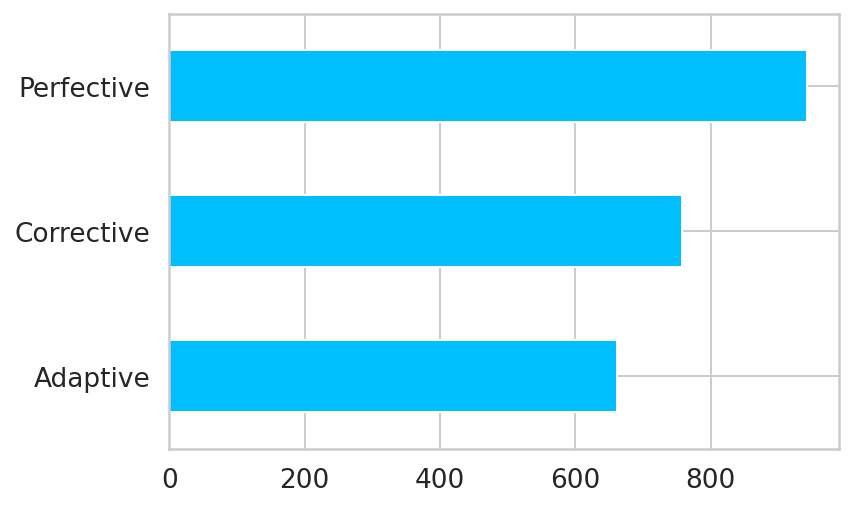

In [73]:
LABEL_COLUMNS = df.columns.tolist()[2:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

### Tokenization

In [10]:
BERT_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [81]:
MAX_TOKEN_COUNT = 1000

tokenized_reviews = df.text.apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
MAX_TOKEN_COUNT = max(map(len, tokenized_reviews))
MAX_TOKEN_COUNT

161

### Dataset


In [20]:
class OwnDataset(Dataset):

  def __init__(
    self, 
    data: pd.DataFrame, 
    tokenizer: BertTokenizer, 
    max_token_len: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    comment_text = data_row.text
    labels = data_row[LABEL_COLUMNS]

    encoding = self.tokenizer.encode_plus(
      comment_text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return dict(
      comment_text=comment_text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor(labels)
    )

In [69]:
train_dataset = OwnDataset(
  train_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)


In [25]:
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)

In [29]:
bert_model.config.hidden_size

768

In [30]:
class OwnDataModule(pl.LightningDataModule):

  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    self.train_dataset = OwnDataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )

    self.test_dataset = OwnDataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )

  def val_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

In [31]:
N_EPOCHS = 10
BATCH_SIZE = 16

data_module = OwnDataModule(
  train_df,
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

## Model


In [32]:
class OwnTagger(pl.LightningModule):

  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)    
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def training_epoch_end(self, outputs):
    
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)

    for i, name in enumerate(LABEL_COLUMNS):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)


  def configure_optimizers(self):

    optimizer = AdamW(self.parameters(), lr=2e-5)

    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

In [35]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

instance of our model



In [37]:
model = OwnTagger(
  n_classes=3,
  n_warmup_steps=total_training_steps // 5,
  n_training_steps=total_training_steps 
)

In [38]:
criterion = nn.BCELoss()


## Training

In [46]:
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Checkpoint directory checkpoints exists and is not empty.
  warnings.warn(*args, **kwargs)


In [82]:
logger = TensorBoardLogger("lightning_logs", name="Commit")

In [78]:
# stopper when val loss is not improving for 2 iterations
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [75]:
trainer = pl.Trainer(
  logger=logger,
  checkpoint_callback=checkpoint_callback,
  callbacks=[early_stopping_callback],
  max_epochs=N_EPOCHS,
  gpus=1,
  progress_bar_refresh_rate=30
)

GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: None, using: 0 TPU cores
INFO:lightning:TPU available: None, using: 0 TPU cores


In [50]:
trainer.fit(model, data_module)


  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 109 M 
1 | classifier | Linear    | 2.3 K 
2 | criterion  | BCELoss   | 0     
-----------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.938   Total estimated model params size (MB)
INFO:lightning:
  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 109 M 
1 | classifier | Linear    | 2.3 K 
2 | criterion  | BCELoss   | 0     
-----------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.938   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: `pos_label` automatically set 1.
  warnings.warn(*args, **kwargs)


Validating: 0it [00:00, ?it/s]

Epoch 0, global step 161: val_loss reached 0.50585 (best 0.50585), saving model to "/content/checkpoints/best-checkpoint-v1.ckpt" as top 1
INFO:lightning:Epoch 0, global step 161: val_loss reached 0.50585 (best 0.50585), saving model to "/content/checkpoints/best-checkpoint-v1.ckpt" as top 1
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 323: val_loss reached 0.36686 (best 0.36686), saving model to "/content/checkpoints/best-checkpoint-v1.ckpt" as top 1
INFO:lightning:Epoch 1, global step 323: val_loss reached 0.36686 (best 0.36686), saving model to "/content/checkpoints/best-checkpoint-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 485: val_loss reached 0.33741 (best 0.33741), saving model to "/content/checkpoints/best-checkpoint-v1.ckpt" as top 1
INFO:lightning:Epoch 2, global step 485: val_loss reached 0.33741 (best 0.33741), saving model to "/content/checkpoints/best-checkpoint-v1.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, step 647: val_loss was not in top 1
INFO:lightning:Epoch 3, step 647: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, step 809: val_loss was not in top 1
INFO:lightning:Epoch 4, step 809: val_loss was not in top 1


1

In [51]:
trainer.test()

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.33740758895874023}
--------------------------------------------------------------------------------


[{'test_loss': 0.33740758895874023}]

## Predictions


In [76]:
trained_model = OwnTagger.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  n_classes=len(LABEL_COLUMNS)
)
trained_model.eval()
trained_model.freeze()

In [77]:
THRESHOLD = 0.5

## Evaluation

In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

val_dataset = OwnDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

predictions = []
labels = []

for item in tqdm(val_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device), 
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

  0%|          | 0/102 [00:00<?, ?it/s]

In [56]:
accuracy(predictions, labels, threshold=THRESHOLD)

tensor(0.8595)

In [62]:
print("ROC per tag")
for i, name in enumerate(LABEL_COLUMNS):
  tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
  print(f"{name}: {tag_auroc}")

ROC per tag
Corrective: 0.8933901786804199
Adaptive: 0.9300318360328674
Perfective: 0.9068322777748108


In [60]:
y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > 0.5, upper, lower)

print(classification_report(
  y_true, 
  y_pred, 
  target_names=LABEL_COLUMNS, 
  zero_division=0
))

              precision    recall  f1-score   support

  Corrective       0.90      0.74      0.81        35
    Adaptive       0.72      0.84      0.78        31
  Perfective       0.81      0.85      0.83        46

   micro avg       0.81      0.81      0.81       112
   macro avg       0.81      0.81      0.81       112
weighted avg       0.81      0.81      0.81       112
 samples avg       0.82      0.83      0.81       112

